In [19]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder

df, y = fetch_openml('adult', version=2, as_frame=True, return_X_y=True)
# we are dropping the following features:
# - "fnlwgt": this feature was created while studying the "adult" dataset.
#   Thus, we will not use this feature which is not acquired during the survey.
# - "education-num": it is encoding the same information than "education".
#   Thus, we are removing one of these 2 features.
df = df.drop(columns=['fnlwgt', 'education-num'])

y = pd.Series(
    LabelEncoder().fit_transform(y),
    name=y.name
)

###############################################################################
# The "adult" dataset as a class ratio of about 3:1

classes_count = y.value_counts()
print(classes_count)

###############################################################################
# This dataset is only slightly imbalanced. To better highlight the effect of
# learning from an imbalanced dataset, we will increase its ratio to 10:1

import numpy as np
import pandas as pd

rng = np.random.RandomState(0)

# we define a ratio 10:1
n_samples_minority_class = classes_count.max() // 10

mask_minority_class = y == classes_count.idxmin()
indices_minority_class = np.flatnonzero(mask_minority_class)
indices_minority_class_subsampled = rng.choice(
    indices_minority_class, size=n_samples_minority_class, replace=False
)

# sample the dataframe
df_res = pd.concat([df.loc[~mask_minority_class, :],
                    df.loc[indices_minority_class_subsampled, :]])
# sample the target
y_res = pd.concat([y.loc[~mask_minority_class],
                   y.loc[indices_minority_class_subsampled]])
print(y_res.value_counts())

###############################################################################
# For the rest of the notebook, we will make a single split to get training
# and testing data. Note that in practise, you should always use
# cross-validation to have an estimate of the performance variation. You can
# refer to the following example showing how to use a scikit-learn pipeline
# within a grid-search:
# :ref:`sphx_glr_auto_examples_compose_plot_compare_reduction.py`

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_res, y_res, stratify=y_res, random_state=42
)

0    37155
1    11687
Name: class, dtype: int64
0    37155
1     3715
Name: class, dtype: int64


In [20]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

num_pipe = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore")
)

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

preprocessor_linear = ColumnTransformer(
    [("num-pipe", num_pipe, selector(dtype_include=np.number)),
     ("cat-pipe", cat_pipe, selector(dtype_include="category"))],
    n_jobs=2
)

In [22]:
from sklearn.linear_model import LogisticRegression

lr_clf = make_pipeline(
    preprocessor_linear, LogisticRegression(max_iter=1000)
)

In [23]:
from sklearn.metrics import balanced_accuracy_score

y_pred = lr_clf.fit(X_train, y_train).predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6347141270720684

## CV strategy by averaging validation score and pick-up the cut-off threshold

In [54]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import _safe_indexing

cv = StratifiedKFold(shuffle=True, random_state=0)

score_val = []
thresholds_val = []
X_val = []
y_true = []
y_score = []
model = []
for train_idx, val_idx in cv.split(X_train, y_train):
    # split the data into the train and validation tests
    X_fold_train = _safe_indexing(X_train, train_idx)
    X_fold_val = _safe_indexing(X_train, val_idx)
    X_val.append(X_fold_val)
    y_fold_train = _safe_indexing(y_train, train_idx)
    y_fold_val = _safe_indexing(y_train, val_idx)
    # train a model for this cv
    model_fold = clone(lr_clf).fit(X_fold_train, y_fold_train)
    model.append(model_fold)
    y_score_model = model_fold.predict_proba(X_fold_val)[:, 1]
    thresholds_fold_val = np.unique(y_score_model)
    score_fold_val = []
    for th in thresholds_fold_val:
        score_fold_val.append(
            balanced_accuracy_score(y_fold_val, (y_score_model >= th).astype(int))
        )
    score_val.append(score_fold_val)
    thresholds_val.append(thresholds_fold_val)
    y_true.append(y_fold_val)
    y_score.append(y_score_model)

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt

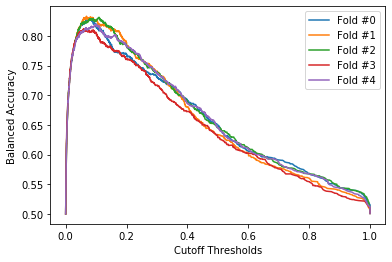

In [56]:
fig, ax = plt.subplots()
for fold_idx in range(len(score_val)):
    ax.plot(thresholds_val[fold_idx], score_val[fold_idx], label=f"Fold #{fold_idx}")
plt.xlabel("Cutoff Thresholds")
plt.ylabel("Balanced Accuracy")
plt.legend()

In [57]:
threshold_interpolated = np.linspace(0, 1, num=1000)
score_val_interpolated = []
for fold_idx in range(len(score_val)):
    score_val_interpolated.append(
        np.interp(
            threshold_interpolated,
            thresholds_val[fold_idx],
            score_val[fold_idx],
        )
    )

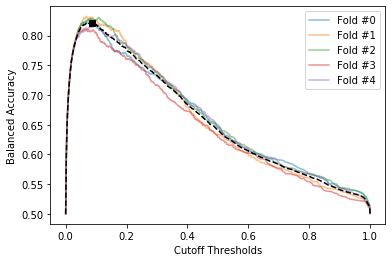

In [58]:
fig, ax = plt.subplots()
for fold_idx in range(len(score_val)):
    ax.plot(threshold_interpolated, score_val_interpolated[fold_idx], label=f"Fold #{fold_idx}", alpha=0.5)
ax.plot(threshold_interpolated, np.mean(score_val_interpolated, axis=0), "--k")
cutoff_points = threshold_interpolated[np.argmax(np.mean(score_val_interpolated, axis=0))]
ax.plot(cutoff_points, np.mean(score_val_interpolated, axis=0).max(), marker="s", color="k")
plt.xlabel("Cutoff Thresholds")
plt.ylabel("Balanced Accuracy")
plt.legend()

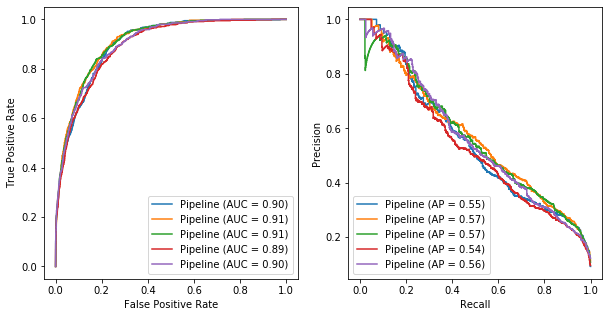

In [62]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
for fold_idx in range(len(y_true)):
    plot_roc_curve(model[fold_idx], X_val[fold_idx], y_true[fold_idx], ax=ax[0])
    plot_precision_recall_curve(model[fold_idx], X_val[fold_idx], y_true[fold_idx], ax=ax[1])